In [1]:
import ast
import csv
import datetime
import gzip
import io
import json
import math
import os
import random
import re
import sys
from collections import Counter, defaultdict

from chebirgroup.utils.atomic import is_biochemical, is_candidate
import df2img
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker
import networkx as nx
import numpy as np
import pandas as pd
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem, Descriptors, Draw, GetPeriodicTable
from rdkit.Chem import rdfiltercatalog
from rdkit.Chem import rdRGroupDecomposition as rdRGD
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.rdRGroupDecomposition import RGroupDecompositionParameters
from rdkit.DataStructs import TanimotoSimilarity
import seaborn as sns
from tqdm import tqdm

RDLogger.DisableLog("rdApp.*")
csv.field_size_limit(sys.maxsize)
%matplotlib ipympl

<frozen importlib._bootstrap>:488: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
<frozen importlib._bootstrap>:488: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry> already registered; second conversion method ignored.


In [39]:
# Colors
ATOM_COLORS = {
    7: (0.33, 0.6, 0.78), # azote
    8: (0.8, 0.38, 0.33), # oxygen
    15: (0.92, 0.6, 0.3), # phosphore
}

def count_log(x) -> float:
    return math.log(x, 10) if x > 0 else 0

def ticker_formatter(x, pos):
    #value = int(np.round(int(x) / 1000) * 1000)
    return f"{x:,.0f}"
    
def draw_rdkit(filename, mol=None, rxn=None, ext: str = "svg"):
    # Draw
    if ext == "svg":
        d2d = Draw.MolDraw2DSVG(1500, 500)
    else:
        d2d = rdMolDraw2D.MolDraw2DCairo(1500, 500)
        
    dopts = d2d.drawOptions()
    dopts.updateAtomPalette(ATOM_COLORS)

    if rxn:
        d2d.DrawReaction(rxn)
    else:
        d2d.DrawMolecule(mol)
    d2d.FinishDrawing()

    if ext == "svg":   
        # Export
        data = d2d.GetDrawingText()
        with open(filename + "." + ext, "w") as fd:
            fd.write(data)
    else:
        d2d.WriteDrawingText(filename + "." + ext)

def compute_weight(smiles) -> float:
    mol = Chem.MolFromSmiles(smiles)
    return Descriptors.MolWt(mol)

def has_isotope(mol) -> bool:
    return any(atom.GetIsotope() != 0 for atom in mol.GetAtoms())

In [3]:
seed = 42
random.seed(a=seed)

# Input
chemical_dir = os.environ["CHEMICALDIR"]
rgroup_dir = os.path.join(chemical_dir, "rgroup")
chebi_dir = os.path.join(rgroup_dir, "chebi")

file_chebi_csv = os.path.join(chebi_dir, "chebis.csv.gz")
file_rhea_csv = os.path.join(rgroup_dir, "rhea", "rhea-chebi-smiles.csv")

# Output
outdir = os.getcwd()
outdir_image = os.path.join(outdir, "image")

## Figure - 1 (paper)

**ChEBI candidates**
* 65286 (retained)
* 141495
* 138603 

**Rhea ID containing ChEBI 138603**
* 16801

In [ ]:
# Figure 1 - 1
# indole + L-serine = H20 + L-tryptophan
mol_sub_a = Chem.MolFromSmiles("O=C(*)[C@@H](N*)CC=1C=CC(=CC1)O") # CHEBI:46858
mol_sub_b = Chem.MolFromSmiles("Nc1ncnc2n(cnc12)[C@@H]1O[C@H](COP([O-])(=O)OS([O-])(=O)=O)[C@@H](OP([O-])([O-])=O)[C@H]1O") # CHEBI:58339
mol_pro_a = Chem.MolFromSmiles("Nc1ncnc2n(cnc12)[C@@H]1O[C@H](COP([O-])([O-])=O)[C@@H](OP([O-])([O-])=O)[C@H]1O") # CHEBI:58343
mol_pro_b = Chem.MolFromSmiles("C=1C=C(C=CC1C[C@@H](C(*)=O)N*)OS([O-])(=O)=O") # CHEBI:65286
mol_pro_c = Chem.MolFromSmiles("[H+]") # CHEBI:15378

rxn_main = AllChem.ChemicalReaction()
rxn_main.AddReactantTemplate(mol_sub_a)
rxn_main.AddReactantTemplate(mol_sub_b)

rxn_main.AddProductTemplate(mol_pro_a)
rxn_main.AddProductTemplate(mol_pro_b)
rxn_main.AddProductTemplate(mol_pro_c)

draw_rdkit(filename=os.path.join(outdir_image, "figure.1.rhea_16801"), rxn=rxn_main, ext="svg")

In [ ]:
# Figure 1 - 2
# CHEBI:65286
with gzip.open(file_chebi_csv, mode="rt") as csvfile:
    reader = csv.DictReader(csvfile)
    for ix, row in enumerate(reader):
        chebis = ast.literal_eval(row["chebi"])
        if "CHEBI:65286" in chebis:
            draw_rdkit(filename=os.path.join(outdir_image, "figure.1.chebi_65286_main"), mol=Chem.MolFromSmiles(row["smiles"]))
            for ix, smiles in enumerate(ast.literal_eval(row["only_match_rgroup_smiles"])):
                draw_rdkit(filename=os.path.join(outdir_image, f"figure.1.chebi_65285_only_match_rgroup_{ix}"), mol=Chem.MolFromSmiles(smiles))
            break

## Figure - 2 (paper)

In [ ]:
# Figure 2
# CHEBI:88242
max_empty = 3
count_empty = 0
is_main = False
with gzip.open(file_chebi_csv, mode="rt") as csvfile:
    reader = csv.DictReader(csvfile)
    for ix, row in enumerate(reader):
        chebis = ast.literal_eval(row["chebi"])
        if "CHEBI:88242" in chebis:
            draw_rdkit(filename=os.path.join(outdir_image, "figure.2.main"), mol=Chem.MolFromSmiles(row["smiles"]))
            
            for ix, smiles in enumerate(ast.literal_eval(row["additional_substituents_smiles"])):
                draw_rdkit(filename=os.path.join(outdir_image, f"figure.2.additional_substituents_{ix}"), mol=Chem.MolFromSmiles(smiles))
                
            for ix, smiles in enumerate(ast.literal_eval(row["only_match_rgroup_smiles"])):
                draw_rdkit(filename=os.path.join(outdir_image, f"figure.2.only_match_rgroup_{ix}"), mol=Chem.MolFromSmiles(smiles))
            
            is_main = True

        if is_candidate(row["smiles"]) and len(ast.literal_eval(row["additional_substituents_smiles"])) < 1 and count_empty < max_empty:
            chebi_id = chebis[0].lower().replace(":", "_")
            draw_rdkit(filename=os.path.join(outdir_image, f"figure.2.empty_{count_empty}_{chebi_id}"), mol=Chem.MolFromSmiles(row["smiles"]))
            count_empty += 1
            
        if count_empty > max_empty - 1 and is_main:
            break

## Figure - 3 (paper)

In [4]:
# Figure 3 - 1
df = pd.read_csv(file_rhea_csv)

def annotate(row):
    expand_label = "no"
    mol = Chem.MolFromSmiles(row["smiles"])
    if not is_biochemical(mol):
        expand_label = "not_biochemical"
    else:
        if row["smiles"].count("*") > 0:
            expand_label = "candidate"
            if int(row["num_heavy_atoms"]) > 5:
                expand_label = "effective"     
    return expand_label

df["expand_label"] = df.apply(annotate, axis=1)

df = df[df["expand_label"] != "not_biochemical"]
df["wt"] = df["smiles"].apply(compute_weight)
df["wt_log"] = df["wt"].apply(count_log)

# no: 10585 - 10389
# effective: 2005 - 1990
# candidate: 119 - 118
#df["expand_label"].value_counts()
df

[23:03:20] WARNING: not removing hydrogen atom with dummy atom neighbors
[23:03:21] WARNING: not removing hydrogen atom without neighbors
[23:03:21] WARNING: not removing hydrogen atom with dummy atom neighbors
[23:03:21] WARNING: not removing hydrogen atom with dummy atom neighbors
[23:03:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[23:03:23] WARNING: not removing hydrogen atom without neighbors
[23:03:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[23:03:23] WARNING: not removing hydrogen atom with dummy atom neighbors


,smiles,chebi,num_heavy_atoms,exact_mol_wt,expand_label,wt,wt_log
0,*,['CHEBI:13193'],0,0.00,candidate,0.000,0.000000
1,**,['CHEBI:17792'],0,0.00,candidate,0.000,0.000000
2,*/C(=N/OS(=O)(=O)[O-])S[C@@H]1O[C@H](CO)[C@@H]...,['CHEBI:183098'],19,316.99,effective,317.297,2.501466
3,*/C([S-])=N/OS(=O)(=O)[O-],['CHEBI:183089'],8,153.93,effective,154.148,2.187938
4,*/C=C(C)/C=C/C=C(C)/C=C/C1=C(C)CCCC1(C)C,['CHEBI:139120'],19,255.21,effective,255.425,2.407263
...,...,...,...,...,...,...,...
12704,c1ccncc1,['CHEBI:16227'],6,79.04,no,79.102,1.898187
12705,c1cn[nH]c1,['CHEBI:17241'],5,68.04,no,68.079,1.833013
12706,c1cncc([C@@H]2CCC[NH2+]2)c1,['CHEBI:190184'],11,149.11,no,149.217,2.173818
12707,c1ncc2c(n1)=NCCN=2,['CHEBI:30156'],10,134.06,no,134.142,2.127565


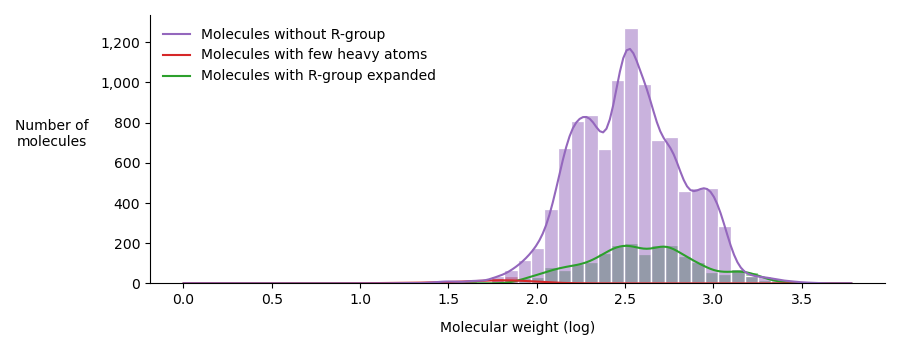

In [22]:
# Figure 3 - 2
# Plot
palette_colors = ["C0", "C1", "C2", "C3", "C4", "C5", "C6"]
formatter = ScalarFormatter(useOffset=False, useLocale=None)
formatter.set_scientific(False)

#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
fig, ax1 = plt.subplots(1, 1, figsize=(9, 3.5))
fig.subplots_adjust(wspace=0.2, hspace=0.25)

# One
with sns.axes_style("darkgrid"):
    ax1 = sns.histplot(data=df, bins=50, kde=True, x="wt_log", hue="expand_label", hue_order=["no", "candidate", "effective"], alpha=.5, ax=ax1, palette=["C4", "C3", "C2"])
sns.despine(ax=ax1)
ax1.set_ylabel("Number of\nmolecules", rotation=0, labelpad=35)
ax1.set_xlabel("Molecular weight (log)", labelpad=10)
#ax1.text(-0.25, 1.05, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold')
ax1.yaxis.set_major_formatter(formatter)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(ticker_formatter))

one_patch = mlines.Line2D([], [], color='C4', label='Molecules without R-group')
two_patch = mlines.Line2D([], [], color='C3', label="Molecules with few heavy atoms")
three_patch = mlines.Line2D([], [], color='C2', label="Molecules with R-group expanded")
ax1.legend(handles=[one_patch, two_patch, three_patch], frameon=False)#, bbox_to_anchor=(1.10, 1.05))

# Two
'''
wildcards = df_expanded["nb_rgroup"].sort_values().unique().tolist()
ax2 = sns.scatterplot(data=df_expanded, x="wt_log", y="nb_smiles_log", hue="no_smiles", size="nb_rgroup", alpha=.7, ax=ax2, legend=True, palette=["C3", "C0"])
sns.despine(ax=ax2)
ax2.set_ylabel("") #, rotation=0, labelpad=35)
ax2.set_xlabel("Molecular weight (log)", labelpad=10)
ax2.text(-0.07, 1, '(log)', transform=ax2.transAxes)
ax2.text(-0.1, 1.05, 'B', transform=ax2.transAxes, fontsize=16, fontweight='bold')

handles, labels = ax2.get_legend_handles_labels()
labels[0] = "In PubChem?"
labels[1] = "No"
labels[2] = "Yes"
labels[3] = "R-group"
ax2.legend(handles=handles, labels=labels, frameon=False, title_fontproperties={'weight': 'bold'}) #, bbox_to_anchor=(1.35, 1.05))
'''

plt.tight_layout()

plt.savefig(os.path.join(outdir_image, "figure.3.svg"))
plt.savefig(os.path.join(outdir_image, "figure.3.png"))
plt.show()

## Figure - 4 (paper)

In [45]:
# Figure 4 - 1
file_rgroup_json = os.path.join("data", "count_rgroup.json")

if not os.path.isfile(file_rgroup_json):

    ps = RGroupDecompositionParameters()
    ps.allowNonTerminalRGroups = True
    ps.onlyMatchAtRGroups = True
    
    regex = re.compile(r'\[\*:\d+\]')
    
    count_rgroup = Counter()
    with gzip.open(file_chebi_csv, mode="rt") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in tqdm(reader):
            if not is_candidate(row["smiles"]):
                continue
            mol_target = Chem.MolFromSmiles(row["smiles"])
            for smiles_query in ast.literal_eval(row["only_match_rgroup_smiles"]):
                mol_query = Chem.MolFromSmiles(smiles_query)            
                matched, _ = rdRGD.RGroupDecompose(
                    [mol_target],
                    [mol_query],
                    asSmiles=True,
                    asRows=True,
                    options=ps,
                )
                if len(matched) < 1:
                    continue
                res = matched[0]
                res.pop("Core")
                for fragment in res.values():
                    fragment = re.sub(regex, "[*:1]", fragment)
                    count_rgroup.update([fragment])
    count_rgroup = dict(count_rgroup)
    with open(file_rgroup_json, "w") as fd:
        json.dump(count_rgroup, fd, indent=4)
else:
    with open(file_rgroup_json) as fd:
        count_rgroup = json.load(fd)
        
count_unique = len(count_rgroup)
count_total_rgroup = sum(count_rgroup.values())
print("Count uniq rgroup:", count_unique)
print("Count total rgroup:", count_total_rgroup)

## Use catalog
use_catalog = False
if use_catalog:
    catalog = rdfiltercatalog.GetFunctionalGroupHierarchy()
        
    rgroups = []
    rgroup_labels = []
    max_rgroup = 20
    for smiles, value in sorted(count_rgroup.items(), key=lambda item: item[1], reverse=True):
        smiles = smiles.replace("[*:1]", "*")
        rgroups.append(smiles)
        # Label
        mol = Chem.MolFromSmiles(smiles)
        matches = catalog.GetMatches(mol)
        labels = [x.GetDescription() for x in matches]
        rgroup_labels.append(labels)
    
        if len(rgroups) > max_rgroup - 1:
            break
    
    for rgroup, label in zip(rgroups, rgroup_labels):
        print("R-group:", rgroup, "label:", label)

## Takeuchi rgroups
takeuchi_rgroups = ["[*]H", "[*]C", "[*]c1ccccc1", "[*]O", "[*]OC", "[*]N", "[*]Cl", "[*]F", "[*]CC", "[*]C#N", "[*]C(=O)O", "[*]Br", "[*]C(F)(F)F", "[*]C(C)C", "[*]Cc1ccccc1", "[*]c1cccnc1", "[*]c1ccncc1", "[*]CCC", "[*]N(C)C", "[*]OCC"]

print("Build fp")
fpgen = AllChem.GetMorganGenerator(radius=2, fpSize=2048, includeChirality=True)
fp_rgroup = {}
for rgroup in tqdm(count_rgroup, total=len(count_rgroup)):
    mol = Chem.MolFromSmiles(rgroup)
    if mol is None:
        continue
    if has_isotope(mol=mol):
        continue
    fp = fpgen.GetCountFingerprint(mol)
    fp_rgroup[rgroup] = fp

print("Match rgroup found with Takeuchi groups")
count_takeuchis = []
for ix, takeuchi_rgroup in tqdm(enumerate(takeuchi_rgroups), total=len(takeuchi_rgroups)):
    if ix < 1:
        count_takeuchis.append(-1)
        continue
    fp1 = fpgen.GetCountFingerprint(Chem.MolFromSmiles(takeuchi_rgroup))
    candidates = []
    for fragment, count in count_rgroup.items():
        fp2 = fp_rgroup.get(fragment)
        similarity = 0.0
        if fp2:
            similarity = TanimotoSimilarity(fp1, fp2)        
        if similarity == 1.0:
            candidates.append((fragment, count))
    res = 0
    if len(candidates) > 1 :
        print("Not Found", "Takeuchi group:", takeuchi_rgroup, "Candidates:", candidates)
        res = -1
    elif len(candidates) < 1:
        res = 0
    else:
        print("Takeuchi rgroup:", takeuchi_rgroup, " -> ", candidates[0])
        res = candidates[0][1]
    count_takeuchis.append(res)

Count uniq rgroup: 6267301
Count total rgroup: 33126945
Build fp


100%|██████████████████████████████████████████████████| 6267301/6267301 [12:49<00:00, 8148.56it/s]


Match rgroup found with Takeuchi groups


 10%|██████▎                                                        | 2/20 [00:11<01:40,  5.58s/it]

Takeuchi rgroup: [*]C  ->  ('C[*:1]', 1196462)


 15%|█████████▍                                                     | 3/20 [00:22<02:17,  8.11s/it]

Takeuchi rgroup: [*]c1ccccc1  ->  ('c1ccc([*:1])cc1', 32784)


 20%|████████████▌                                                  | 4/20 [00:33<02:26,  9.15s/it]

Takeuchi rgroup: [*]O  ->  ('O[*:1]', 1289055)


 25%|███████████████▊                                               | 5/20 [00:44<02:25,  9.71s/it]

Takeuchi rgroup: [*]OC  ->  ('CO[*:1]', 2861754)


 30%|██████████████████▉                                            | 6/20 [00:55<02:22, 10.15s/it]

Takeuchi rgroup: [*]N  ->  ('N[*:1]', 161098)


 35%|██████████████████████                                         | 7/20 [01:06<02:15, 10.44s/it]

Takeuchi rgroup: [*]Cl  ->  ('Cl[*:1]', 921787)


 45%|████████████████████████████▎                                  | 9/20 [01:28<01:57, 10.71s/it]

Takeuchi rgroup: [*]CC  ->  ('CC[*:1]', 73982)


 50%|███████████████████████████████                               | 10/20 [01:39<01:47, 10.80s/it]

Takeuchi rgroup: [*]C#N  ->  ('N#C[*:1]', 62790)


 55%|██████████████████████████████████                            | 11/20 [01:50<01:38, 10.95s/it]

Takeuchi rgroup: [*]C(=O)O  ->  ('O=C(O)[*:1]', 116304)


 70%|███████████████████████████████████████████▍                  | 14/20 [02:24<01:07, 11.27s/it]

Takeuchi rgroup: [*]C(C)C  ->  ('CC(C)[*:1]', 79628)


 75%|██████████████████████████████████████████████▌               | 15/20 [02:36<00:56, 11.38s/it]

Takeuchi rgroup: [*]Cc1ccccc1  ->  ('c1ccc(C[*:1])cc1', 13697)


 80%|█████████████████████████████████████████████████▌            | 16/20 [02:50<00:48, 12.15s/it]

Takeuchi rgroup: [*]c1cccnc1  ->  ('c1cncc([*:1])c1', 2202)


 85%|████████████████████████████████████████████████████▋         | 17/20 [03:02<00:36, 12.07s/it]

Takeuchi rgroup: [*]c1ccncc1  ->  ('c1cc([*:1])ccn1', 1757)


 90%|███████████████████████████████████████████████████████▊      | 18/20 [03:13<00:23, 11.86s/it]

Takeuchi rgroup: [*]CCC  ->  ('CCC[*:1]', 25830)


 95%|██████████████████████████████████████████████████████████▉   | 19/20 [03:24<00:11, 11.72s/it]

Takeuchi rgroup: [*]N(C)C  ->  ('CN(C)[*:1]', 17896)


100%|██████████████████████████████████████████████████████████████| 20/20 [03:36<00:00, 10.82s/it]

Takeuchi rgroup: [*]OCC  ->  ('CCO[*:1]', 152950)


Rotate smiles: *c1ccccc1
Rotate smiles: *c1cccnc1
Rotate smiles: *c1ccncc1
n cols: 4
n rows: 5


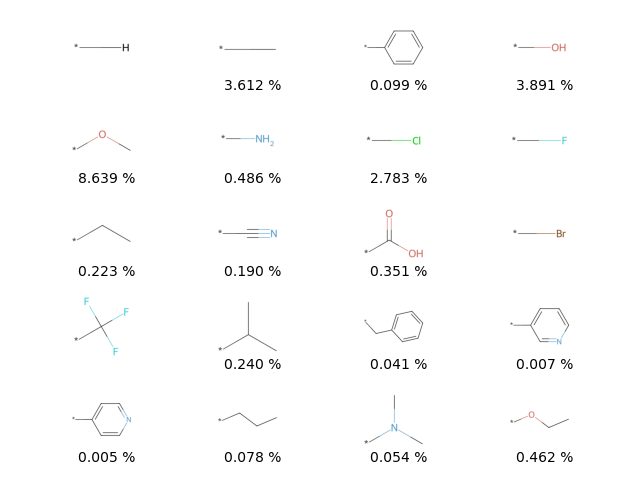

In [69]:
# Figure 4 - 2
# build the molecules
# https://github.com/klausweinbauer/FGUtils
# https://github.com/jeffrichardchemistry/pyCheckmol
#rgroups = ["[H][*]", "[*]C", "[*]c1ccccc1", "[*]O", "[*]CO", "[*]N", "[*]Cl", "[*]F", "[*]CC", "[*]C#N"] #, "[*]C(=O)O", "[*]Br", "[*]C(C)(F)F", "[*]C(C)C", "[*]Cc1ccccc1", "[*]c1cnccn1", "[*]c1ccncc1", "[*]CCC", "[*]N(C)C", "[*]COC"]

labels = [f"({ix})" for ix in range(1, len(rgroups) + 1)]
percs = []
for count_takeuchi in count_takeuchis:
    if count_takeuchi < 0:
        percs.append("")
    elif count_takeuchi == 0:
        percs.append("")
    else:
        perc = count_takeuchi * 100.0 / count_total_rgroup
        percs.append(f"{perc:.3f} %")
        
mols = []
for rgroup in rgroups:
    mol = None
    if rgroup == "[*]H":
        mol = Chem.RWMol()
        r_idx = mol.AddAtom(Chem.Atom(0))
        h_idx = mol.AddAtom(Chem.Atom(1))
        mol.AddBond(r_idx, h_idx, Chem.BondType.SINGLE)
    else:
        mol = Chem.MolFromSmiles(rgroup)
    mols.append(mol)
rotates = [False] * len(rgroups) #, False, True, False, False, False, False, False, False, False]
rotates[2] = True
rotates[15] = True
rotates[16] = True

imgs = []
for ix, mol in enumerate(mols):
    d2d = rdMolDraw2D.MolDraw2DCairo(250, 250)
    dopts = d2d.drawOptions()
    dopts.updateAtomPalette(ATOM_COLORS)
    if rotates[ix]:
        print("Rotate smiles:", Chem.MolToSmiles(mol))
        dopts.rotate = 180
    d2d.DrawMolecule(mol)
    d2d.FinishDrawing()
    png_bytes = d2d.GetDrawingText()
    arr = plt.imread(io.BytesIO(png_bytes), format='png')
    imgs.append(arr)

# Plot
n_cols = 4
n_rows = -(-len(mols) // n_cols)
print("n cols:", n_cols)
print("n rows:", n_rows)
fig, axes = plt.subplots(n_rows, n_cols)#, figsize=(300, 600))

ix, ij = 0, 0
for i in range(len(mols)):
    axes[ix, ij].imshow(np.asarray(imgs[i])) # convert to numeric array
    axes[ix, ij].axis('off')
    #axes[ix, ij].text(-0.6, 0.5, labels[i], transform=axes[ix, ij].transAxes, fontsize=12, va='center')
    axes[ix, ij].text(0.15, -0.1, percs[i], transform=axes[ix, ij].transAxes, fontsize=10, va='center')

    # Update
    ij += 1
    if ij > n_cols - 1:
        ij = 0
        ix += 1
        
fig.tight_layout()
plt.savefig(os.path.join(outdir_image, "figure.5.svg"))
plt.savefig(os.path.join(outdir_image, "figure.5.png"))
plt.show()